## Basic setup

In [2]:
import numpy as np
import time
import matplotlib.pyplot as plt

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import learning_curve
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.neighbors import NearestCentroid
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier

import warnings
warnings.filterwarnings('ignore')

seed = 1234
np.random.seed(seed)  

In [3]:
# loading and combining batches of samples
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return np.array(dict[b'data']), np.array(dict[b'labels'])

def load_class_labels(file="cifar-10-batches-py/batches.meta"):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return [name.decode('utf-8') for name in dict[b'label_names']]

X_partial, y_partial = [], []
for i in range(1, 6):
    X_batch, y_batch = unpickle(f"cifar-10-batches-py/data_batch_{i}")
    X_partial.append(X_batch)
    y_partial.append(y_batch)

X_train_full = np.vstack(X_partial)
y_train_full = np.hstack(y_partial)

X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, random_state=seed, test_size=0.2, shuffle=True)  # use train_test_split to split out the validation set from the training set
X_test_original, y_test = unpickle("cifar-10-batches-py/test_batch")  # keeping the original test data for display purposes

scaler = StandardScaler().fit(X_train)  # scale the data
X_train = scaler.transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test_original)

class_labels = load_class_labels()

In [3]:
print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)
print(X_test.shape, y_test.shape)
print(class_labels)

(40000, 3072) (40000,)
(10000, 3072) (10000,)
(10000, 3072) (10000,)
['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


## Some helper funtions

In [4]:
def visualize_sample_prediction(clf):  # display some sample images and their predictions given a classifier
    figure, axes = plt.subplots(4, 8, figsize=(12, 6))
    for i, ax in enumerate(axes.ravel()):
        image = X_test_original[i].reshape(3,32,32).transpose(1,2,0)

        predicted = clf.predict([X_test_original[i]])[0]

        ax.imshow(image)
        ax.set_title(f"True: {class_labels[y_test[i]]}\nPred: {class_labels[predicted]}")

    figure.suptitle(f"CIFAR-10: {clf.__class__.__name__} Predictions", fontsize=16)
    plt.tight_layout()
    plt.show()

In [5]:
def plot_learning_curve(clf):  # sklearn's learning_curve funtion uses n fold cross validation instead scoring against dedicated validation set
    train_sizes, train_scores, val_scores = learning_curve(clf, X_train_full, y_train_full, train_sizes=np.linspace(0.1, 1.0, 10), shuffle=True, random_state=seed, cv=5, scoring='accuracy', n_jobs=1)
    train_means = np.mean(train_scores, axis=1)
    val_means = np.mean(val_scores, axis=1)

    train_error = 1 - train_means
    val_error = 1 - val_means

    plt.figure(figsize=(8,5))
    plt.plot(train_sizes, train_error, label="Training Error")
    plt.plot(train_sizes, val_error, label="Validation Error")
    plt.xlabel("Training size")
    plt.ylabel("Error rate")
    plt.title(f"Learning Curve: {clf.__class__.__name__}")
    plt.legend()
    plt.tight_layout()
    plt.show()


## Find the best parameters for KNN (n_neighbors and weights)

1 uniform 0.66164
1 distance 0.66164
3 uniform 0.6757000000000001
3 distance 0.65526
5 uniform 0.66794
5 distance 0.6518200000000001
7 uniform 0.6674599999999999
7 distance 0.65204
9 uniform 0.66748
9 distance 0.6535599999999999
11 uniform 0.67056
11 distance 0.65808
13 uniform 0.6718
13 distance 0.66088
15 uniform 0.67286
15 distance 0.66404
17 uniform 0.67372
17 distance 0.66572
19 uniform 0.6763399999999999
19 distance 0.66846
21 uniform 0.67954
21 distance 0.67116


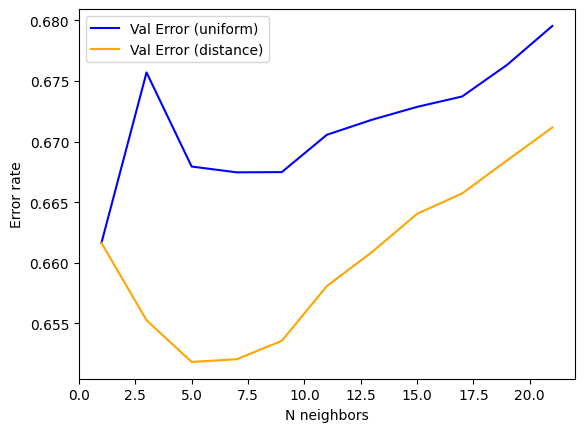

Best parameter: {'n_neighbors': 5, 'weights': 'distance'}


In [6]:
# can take a while due to knn iterating all training points for predicting each of the validation points
# took 23 mins to run locally
def knn_find_best_hyperparameter():
    neighbors = [i for i in range(1, 22, 2)]
    weights = ["uniform", "distance"]

    uniform_val_error = []

    distance_val_error = []

    best_val_error = np.inf
    best_parameter = {
        "n_neighbors": 1,
        "weights": "uniform"
    }
    for n in neighbors:
        for weight in weights:
            knn_clf = KNeighborsClassifier(n_neighbors=n, weights=weight)
            # using the full training set (before split) for 5 fold cross validation and take the average of scores
            cross_val_error = 1 - np.mean(cross_val_score(knn_clf, X_train_full, y_train_full, cv=5)) 
            print(n, weight, cross_val_error)

            if cross_val_error < best_val_error:  # save the best parameters
                best_val_error = cross_val_error
                best_parameter["n_neighbors"] = n
                best_parameter["weights"] = weight

            if weight == "uniform":  # save errors for later plot
                uniform_val_error.append(cross_val_error)
            else:
                distance_val_error.append(cross_val_error)

    plt.plot(neighbors, uniform_val_error, label="Val Error (uniform)", color = "blue")
    plt.plot(neighbors, distance_val_error, label="Val Error (distance)", color = "orange")
    plt.xlabel("N neighbors")
    plt.ylabel("Error rate")
    plt.legend()
    plt.show()

    return best_parameter

knn_best_parameter = knn_find_best_hyperparameter()
print(f"Best parameter: {knn_best_parameter}")

## KNN learning curve

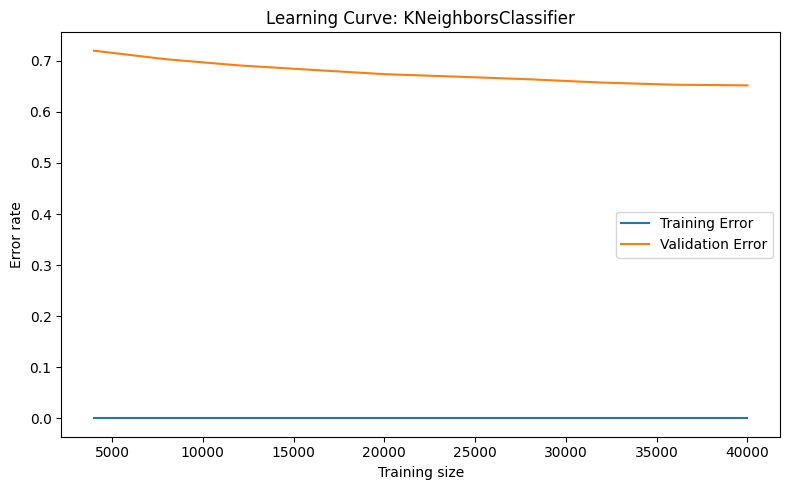

In [8]:
# took 22 mins to run locally
knn_best = KNeighborsClassifier(**knn_best_parameter)
knn_best.fit(X_train, y_train)
plot_learning_curve(knn_best)

## Measuring KNN performance on test set

knn training error: 0.0
knn test error: 0.65
knn prediction time per sample (trained on 50,000 data): 0.20759983062744142 ms


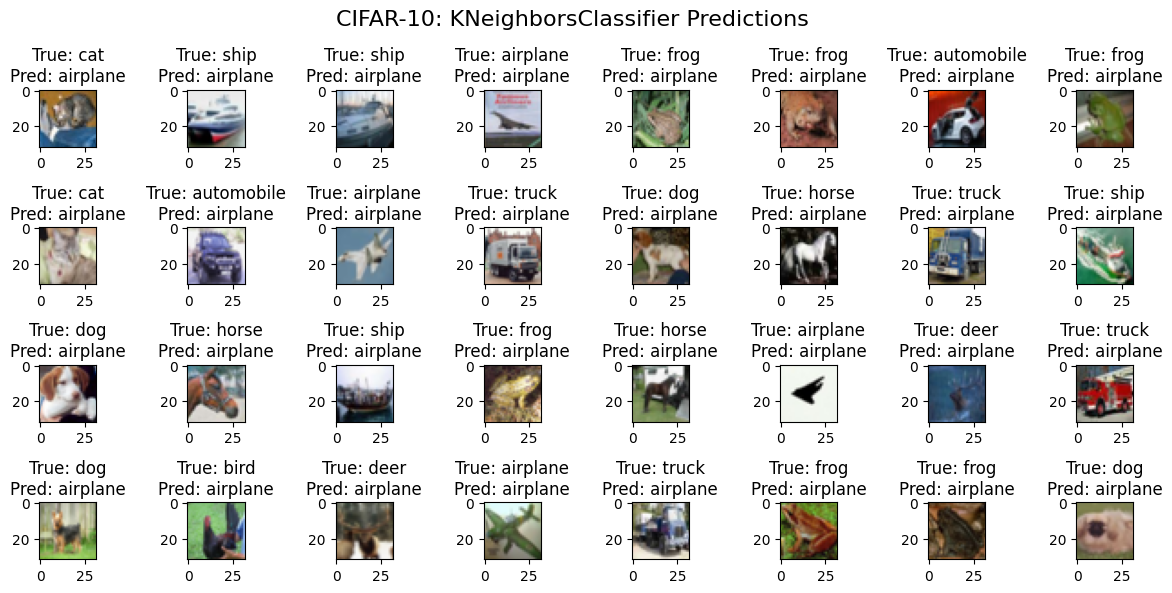

In [ ]:

knn_best = KNeighborsClassifier(**knn_best_parameter)
knn_best.fit(X_train, y_train)
knn_train_error = 1 - knn_best.score(X_train, y_train)

start_time = time.time()
knn_test_error = 1 - knn_best.score(X_test, y_test)
end_time = time.time()
elapsed_time = end_time - start_time
time_per_sample = elapsed_time / len(X_train)

print(f"knn training error: {knn_train_error}")
print(f"knn test error: {knn_test_error}")
print(f"knn prediction time per sample (trained on 40,000 data): {time_per_sample * 1000} ms")
visualize_sample_prediction(knn_best)

## Find the best parameters for logistic 

0.01 l1 0.584425 0.6081
0.01 l2 0.5171 0.6083000000000001
0.1 l1 0.532525 0.6002000000000001
0.1 l2 0.5085500000000001 0.6172
1 l1 0.509925 0.6142000000000001
1 l2 0.50825 0.618
10 l1 0.50825 0.6179
10 l2 0.5081249999999999 0.6182000000000001
50 l1 0.50825 0.618
50 l2 0.5081249999999999 0.6183000000000001
100 l1 0.508175 0.6181
100 l2 0.5081249999999999 0.6183000000000001


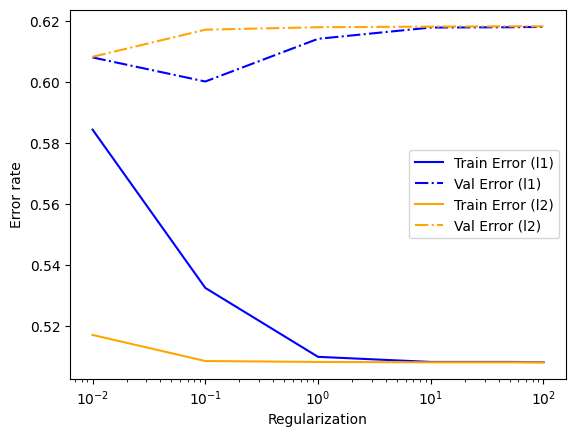

Best parameter: {'C': 0.1, 'penalty': 'l1', 'solver': 'saga', 'random_state': 1234, 'n_jobs': -1, 'multi_class': 'ovr'}


In [ ]:
# took 165 mins single thread/29mins multithreads
def logistic_find_best_hyperparameter():
    regularizations = [0.01, 0.1, 1, 10, 50, 100]
    penalties = ["l1", "l2"]

    l1_train_error = []
    l1_val_error = []

    l2_train_error = []
    l2_val_error = []

    best_val_error = np.inf
    best_parameter = {
        "C": 0,
        "penalty": "l1",
        "solver": "saga",
        "random_state": seed,
        "n_jobs": -1,  # enables utilization of all cores to speed up
        "multi_class": "ovr"
    }
    for c in regularizations:
        for p in penalties:
            logistic_clf = LogisticRegression(random_state=seed, penalty=p, C=c, solver='saga', n_jobs=-1, multi_class="ovr").fit(X_train, y_train)

            train_error = 1 - logistic_clf.score(X_train, y_train)
            val_error = 1 - logistic_clf.score(X_val, y_val)
            print(c, p, train_error, val_error)

            if val_error < best_val_error:
                best_val_error = val_error
                best_parameter["C"] = c
                best_parameter["penalty"] = p

            if p == "l1":  # save errors for later plot
                l1_train_error.append(train_error)
                l1_val_error.append(val_error)
            else:
                l2_train_error.append(train_error)
                l2_val_error.append(val_error)

    plt.semilogx(regularizations, l1_train_error, label="Train Error (l1)", color = "blue")
    plt.semilogx(regularizations, l1_val_error, label="Val Error (l1)",  linestyle='-.', color = "blue")
    plt.semilogx(regularizations, l2_train_error, label="Train Error (l2)", color = "orange")
    plt.semilogx(regularizations, l2_val_error, label="Val Error (l2)", linestyle='-.', color = "orange")
    plt.xlabel("Regularization")
    plt.ylabel("Error rate")
    plt.legend()
    plt.show()

    return best_parameter

logistic_best_parameter = logistic_find_best_hyperparameter()
print(f"Best parameter: {logistic_best_parameter}")

## Logistic learning curve

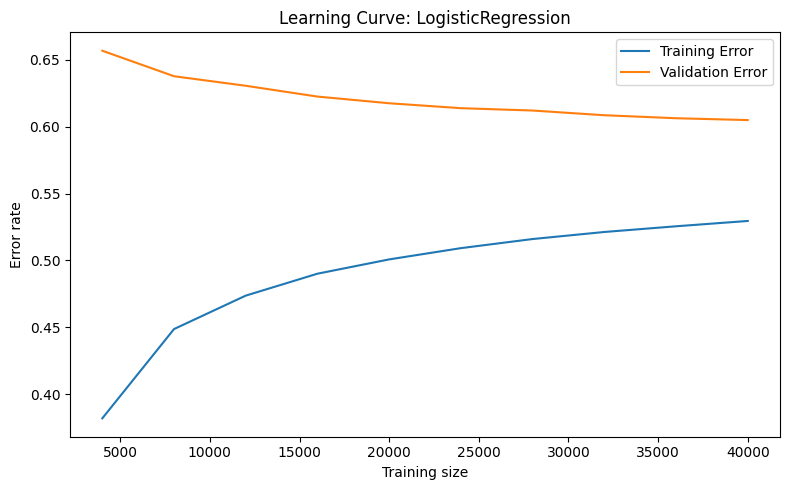

In [ ]:
# took 84 mins to run using multithreading parameters (sage+ovr)
logistic_best = LogisticRegression(**logistic_best_parameter)
logistic_best.fit(X_train, y_train)
plot_learning_curve(logistic_best)

## Measuring logistic performance on test set

logistic training error: 0.532525
logistic test error: 0.5929
logistic prediction time per sample: 0.0012998342514038087 ms


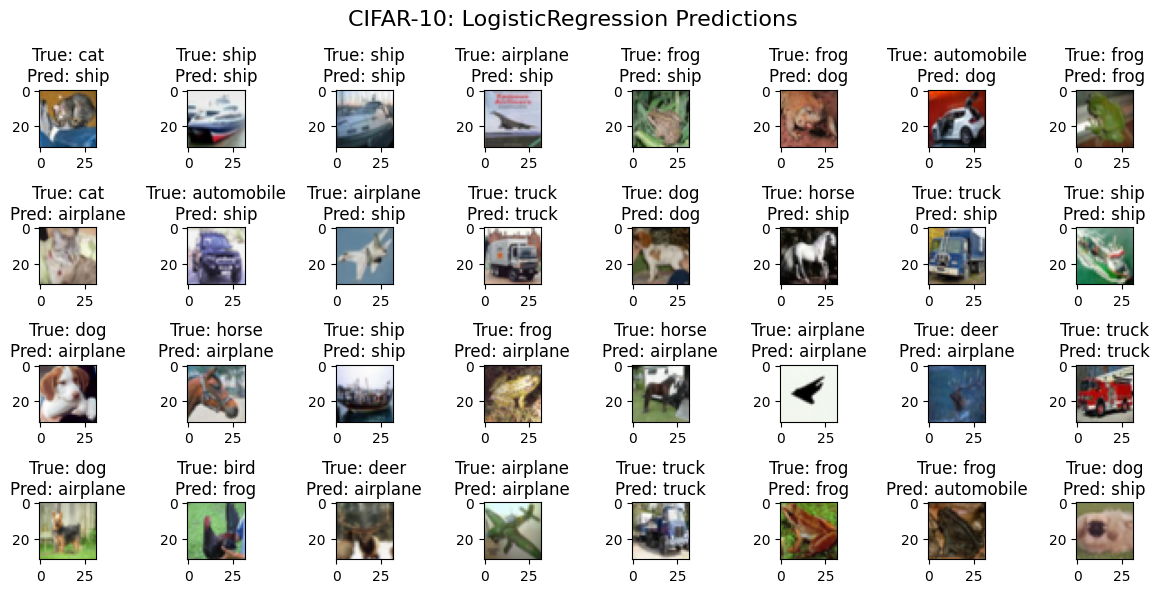

In [9]:
logistic_train_error = 1 - logistic_best.score(X_train, y_train)

start_time = time.time()
logistic_test_error = 1 - logistic_best.score(X_test, y_test)
end_time = time.time()
elapsed_time = end_time - start_time
time_per_sample = elapsed_time / len(X_train)

print(f"logistic training error: {logistic_train_error}")
print(f"logistic test error: {logistic_test_error}")
print(f"logistic prediction time per sample: {time_per_sample * 1000} ms")
visualize_sample_prediction(logistic_best)